# AAPL Demo: volatility surface fitting, and computing implied probability distributions

This notebook is a full walk-through of how to fit a volatility surface and use it to infer implied probability distributions (across multiple expiry dates),
using AAPL CSV data.

Goals for this notebook:
1. Fit a VolSurface to multiple expiries, and use the fitted surface to price options and compute Greeks
2. Derive the implied probability (ProbSurface) and query tail probabilities and moments for a selected expiry


---

## Goal 1: Fitting a volatility surface using the `VolSurface` object

We will:
1) Load input data
3) Fit a vol surface
4) Use the fitted surface to price options and compute greeks


In [1]:
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from oipd import VolSurface, MarketInputs, sources


### 1.1 Load input data

First, upload options chain data from a CSV


In [2]:
# map the raw data column names to the naming conventions accepted by OIPD
# raw column names : OIPD names
COLUMN_MAPPING = {
    "strike": "strike",
    "last_price": "last_price",
    "bid": "bid",
    "ask": "ask",
    "expiration": "expiry",
    "type": "option_type",
}

# `sources` is convenient method to ingest CSV or DataFrame files 
# Alternatively, you can use pandas.read_csv()
df_aapl = sources.from_csv("data/AAPL_data.csv", column_mapping=COLUMN_MAPPING)

# Use the full chain (multiple expiries) for surface fitting
df_chain = df_aapl.copy()


<B>The `MarketInputs` object</B>

`MarketInputs` is a snapshot of market conditions (valuation date, underlying price, risk free rate) that the model uses to fit the volatility surface.



In [3]:
# define the market conditions
market = MarketInputs(
    valuation_date=date(2025, 10, 6), # date on which the options data was downloaded
    risk_free_rate=0.04,              # the risk-free rate of return. Use the US Fed or Treasury yields that are closest to the horizon of the expiries (e.g. 3-month since we're evaluating on Oct 2025)
    underlying_price=256.69,          # the price of the underlying stock at the time when the options data was downloaded
)


### 1.2 Fitting the Volatility Surface

Now that all input data is loaded and defined, we can fit the vol surface. 

We first initialize a `VolSurface` object, which is a shell used to store the fitted vol surface. 

Once fitted, it can be queried using convenient methods, like `vol_surface.plot()`.



In [4]:
vol_surface = VolSurface() # initialize the VolSurface object
vol_surface.fit(df_chain, market) # fit using the input data we defined, which populates the VolSurface object with results


/Users/henrytian/Coding Projects/Github/probabilistic/oipd/pipelines/vol_surface/svi_slices.py:115: UserWarning: Filled missing mid prices with last_price for 12 expiries: [2025-10-10, 2025-10-17, 2025-10-24 ... 2027-01-15]
  warnings.warn(


### 1.3 Use the fitted vol surface to price options, compute Greeks, etc.

First, let's visualize the fit. 

<i> Note: We fit each expiry independently, so you may see lines cross in this raw plot. For actual pricing, however, the model has a basic calendar arbitrage prevention by ensuring that total variance never decreases over time. </i>


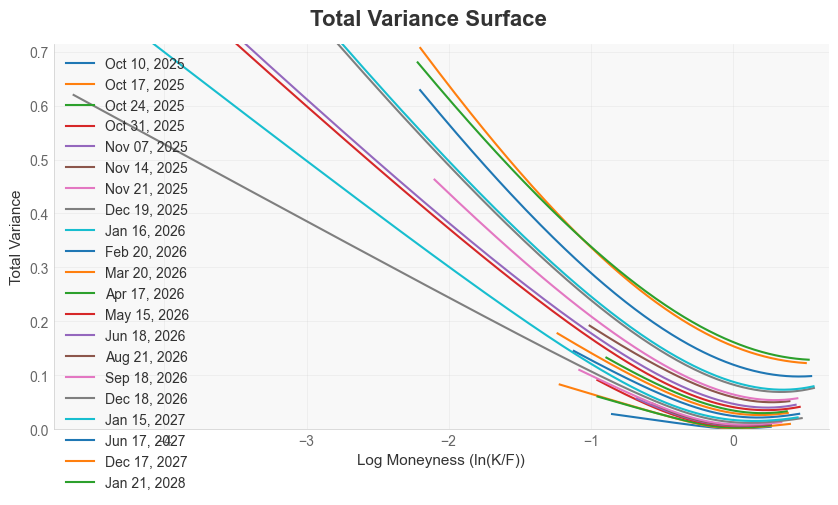

In [14]:
vol_surface.plot()
plt.show()

Now that the vol surface has been fitted, we can evaluate the theoretical IV and total variance at a set of strikes and a time-to-expiry. 



In [6]:
strikes = np.array([220.0, 240.0, 260.0, 280.0, 300.0])
t = 0.25  # time to expiry in years (~3 months)

print(vol_surface.implied_vol(strikes, t))
print(vol_surface.total_variance(strikes, t))


[0.29503723 0.26593503 0.24660472 0.23639289 0.23393967]
[0.02176174 0.01768036 0.01520347 0.0139704  0.01368194]


We can also find theoretical options prices and Greeks.


In [7]:
call_prices = vol_surface.price(strikes, t=t, call_or_put="call")
put_prices = vol_surface.price(strikes, t=t, call_or_put="put")

# Bulk Greeks
all_greeks = vol_surface.greeks(strikes, t=t, call_or_put="call")
all_greeks["call_price"] = call_prices
all_greeks["put_price"] = put_prices
all_greeks


,strike,delta,gamma,vega,theta,rho,call_price,put_price
0,220.0,0.873178,0.005120,25.369754,-16.615187,-10.282144,41.128575,2.337129
1,240.0,0.733084,0.009310,41.579162,-23.103517,-6.180036,24.720145,5.729696
2,260.0,0.509270,0.012351,51.151483,-25.717722,-3.058298,12.233193,13.043740
3,280.0,0.273317,0.010804,42.891894,-20.473217,-1.215872,4.863489,25.475033
4,300.0,0.115494,0.006403,25.157515,-11.835898,-0.407601,1.630406,42.042947


Lastly, we can download a DataFrame of fitted theoretical IV vs raw IV observed in market data (note that market IV only exists at a small set of strikes).

Also note that our data came from Yahoo Finance, whose raw IV is usually inaccurate (see https://chasethedevil.github.io/post/yahoo_finance_implied_volatility/)



In [8]:
vol_surface.iv_results().head(10)


,strike,fitted_iv,market_iv,market_bid_iv,market_ask_iv,market_last_iv,expiry
0,109.750000,1.593648,NaN,NaN,NaN,NaN,2025-10-10
1,110.883166,1.582701,NaN,NaN,NaN,NaN,2025-10-10
2,112.016332,1.571793,NaN,NaN,NaN,NaN,2025-10-10
3,113.149497,1.560924,NaN,NaN,NaN,NaN,2025-10-10
4,114.282663,1.550091,NaN,NaN,NaN,NaN,2025-10-10
5,115.415829,1.539293,NaN,NaN,NaN,NaN,2025-10-10
6,116.548995,1.528530,NaN,NaN,NaN,NaN,2025-10-10
7,117.682161,1.517799,NaN,NaN,NaN,NaN,2025-10-10
8,118.815327,1.507099,NaN,NaN,NaN,NaN,2025-10-10
9,119.948492,1.496430,NaN,NaN,NaN,NaN,2025-10-10


---

## Goal 2: Build the `ProbSurface` to understand market-implied probabilities

The probability surface is the risk-neutral distribution implied by the fitted
surface. You can query tail probabilities, quantiles, and moments for a selected expiry.



In [ ]:
# use the vol_surface.implied_distribution() method 
prob_surface = vol_surface.implied_distribution() # --> returns a `ProbSurface` object. This is a container that holds information about market-implied probabilities over time. 


Now, we can query the result to quantify probabilities and other statistics.


In [ ]:
spot = market.underlying_price
print(spot) # $256.69

# pick a specific expiry to query
print(vol_surface.expiries)
expiry = '2026-01-16' # let's say we're interested in Jan 2026
prob_curve = prob_surface.slice(expiry) # create a slice of the surface, which creates a ProbCurve object. 

prob_below = prob_curve.prob_below(240) # calculates Prob(price at expiry < 240)
prob_above = prob_curve.prob_above(280) # calculates Prob(price at expiry >= 280)
prob_between = prob_curve.prob_between(240, 280)

quantiles = {
    "q10": prob_curve.quantile(0.10),
    "q50": prob_curve.quantile(0.50),
    "q90": prob_curve.quantile(0.90),
}

moments = {
    "mean": prob_curve.mean(),
    "variance": prob_curve.variance(),
    "skew": prob_curve.skew(),
    "kurtosis": prob_curve.kurtosis(),
}

{
    "prob_below": prob_below,
    "prob_above": prob_above,
    "prob_between": prob_between,
    **quantiles,
    **moments,
}


256.69
(Timestamp('2025-10-10 00:00:00'), Timestamp('2025-10-17 00:00:00'), Timestamp('2025-10-24 00:00:00'), Timestamp('2025-10-31 00:00:00'), Timestamp('2025-11-07 00:00:00'), Timestamp('2025-11-14 00:00:00'), Timestamp('2025-11-21 00:00:00'), Timestamp('2025-12-19 00:00:00'), Timestamp('2026-01-16 00:00:00'), Timestamp('2026-02-20 00:00:00'), Timestamp('2026-03-20 00:00:00'), Timestamp('2026-04-17 00:00:00'), Timestamp('2026-05-15 00:00:00'), Timestamp('2026-06-18 00:00:00'), Timestamp('2026-08-21 00:00:00'), Timestamp('2026-09-18 00:00:00'), Timestamp('2026-12-18 00:00:00'), Timestamp('2027-01-15 00:00:00'), Timestamp('2027-06-17 00:00:00'), Timestamp('2027-12-17 00:00:00'), Timestamp('2028-01-21 00:00:00'))


{'prob_below': 0.01758351443582673,
 'prob_above': 0.003404170881012192,
 'prob_between': 0.9790123146831611,
 'q10': 248.141420315573,
 'q50': 257.001439362593,
 'q90': 265.58260757266737,
 'mean': 256.41689186115696,
 'variance': 52.39713292911301,
 'skew': 0.12286277139951862,
 'kurtosis': 1.2329598192893165}

Plot the probability distribution over time as a fan-chart


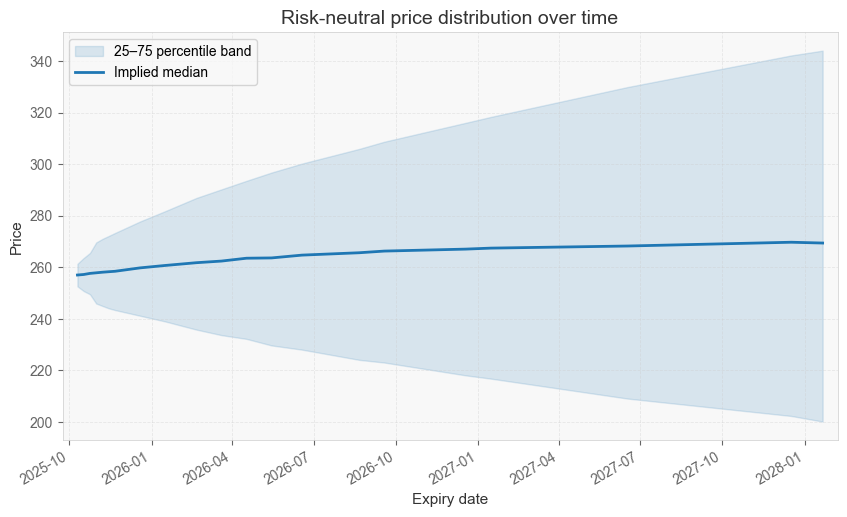

In [13]:
prob_surface.plot_fan()
plt.show()
